In [1]:
%load_ext autoreload
%autoreload 2

if __name__ == '__main__':
    import sys
    import os
    from pathlib import Path
    curr_file_path = Path(os.path.abspath(''))
    print(curr_file_path)
    sys.path.append(str(curr_file_path.parent))

import numpy as np
import glob2 as glob
import matplotlib as mpl
import matplotlib.pyplot as plt
import torch
from torch.distributions.utils import logits_to_probs
from sklearn.decomposition import PCA
from agents.networks.a2c_rnn_split_vanilla import A2CRNN
from copy import deepcopy as copy
from nb_analysis_tools import load_numpy, load_compressed_data, parse_all_sessions, gen_alignment_chart, find_odor_site_trajectories_by_patch_type
from aux_funcs import compressed_write, logical_and, format_plot, compressed_read, sample_truncated_exp
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import r2_score
from numpy.linalg import norm
from torch.distributions.categorical import Categorical
from environments.treadmill_session import TreadmillSession
from environments.components.patch_type import PatchType
from agents.a2c_recurrent_agent_split import A2CRecurrentAgent
from environments.curriculum import Curriculum

from scipy.cluster.hierarchy import linkage, leaves_list


DATA_BASE_DIR = '../../results/rl_agent_outputs'
PATCH_TYPES_PER_ENV = 3
OBS_SIZE = PATCH_TYPES_PER_ENV + 1
ACTION_SIZE = 2
HIDDEN_SIZE = 128
NUM_ENVS = 30
DEVICE = 'cuda'

plt.rcParams['font.family'] = 'Helvetica Light'

C:\Users\david.bell\work\favorably_connected\code\notebooks


In [2]:
# Load weights from given `load_path`
def load_network(load_path):
    
    network = A2CRNN(
        input_size=OBS_SIZE + ACTION_SIZE + 1,
        action_size=ACTION_SIZE,
        hidden_size=HIDDEN_SIZE,
        device=DEVICE,
        var_noise=0,
    )

    saved_checkpoint = torch.load(os.path.join(DATA_BASE_DIR, load_path).replace('\\','/'), weights_only=True)
    if 'network_state_dict' in saved_checkpoint:
        network.load_state_dict(saved_checkpoint['network_state_dict'])
    else:
        network.load_state_dict(saved_checkpoint)
    network.eval()

    return network


# Load hidden states and behavior of network from `load path`
def load_hidden_and_behavior(load_path):
    data = load_numpy(os.path.join(DATA_BASE_DIR, load_path, 'hidden_state/*.npy').replace('\\','/'))
    data = np.transpose(data, [2, 1, 0])
    
    flattened_data = data.reshape(data.shape[0], data.shape[1] * data.shape[2], order='C')
    
    pca = PCA()
    pc_activities = pca.fit_transform(flattened_data.T)
    pc_activities = pc_activities.T.reshape(data.shape, order='C')
    
    all_session_data = parse_all_sessions(
        os.path.join(DATA_BASE_DIR, load_path, 'state'),
        30,
    )

    return data, pc_activities, all_session_data, pca

In [3]:
weight_paths = [
    'he_init_vanilla_inoise_0p05_2025-07-06_15_02_35_603284_var_noise_0.0001_activity_weight_1/rnn_weights/02550.pth',
]

hidden_and_behavior_paths = [
    'test_he_init_linear_603284_2550_2025-07-09_09_35_34_648819_var_noise_0.0_activity_weight_1',
]


In [4]:
for i, (weight_path, hidden_and_behavior_path) in enumerate(zip(weight_paths, hidden_and_behavior_paths)):
    network = load_network(weight_path)
    # acc_reward_vec_path = os.path.join(DATA_BASE_DIR, Path(weight_path).parents[1], 'stored_pcs_and_weights/rewards_seen_in_patch.pkl').replace('/', '\\')
    # acc_reward_vec = compressed_read(acc_reward_vec_path)
    hidden_activities, pc_activities, all_session_data, pca = load_hidden_and_behavior(hidden_and_behavior_path)

['00000.pkl', '00001.pkl', '00002.pkl', '00003.pkl', '00004.pkl', '00005.pkl', '00006.pkl', '00007.pkl']
00000.pkl
00001.pkl
00002.pkl
00003.pkl
00004.pkl
00005.pkl
00006.pkl
00007.pkl


In [5]:
def cosine(u, v):
    return np.dot(u, v) / (norm(u)*norm(v))

In [6]:
flattened_ha = hidden_activities.reshape(hidden_activities.shape[0], hidden_activities.shape[1] * hidden_activities.shape[2], order='C')

print(flattened_ha.shape)

pca = PCA()
pc_activities = pca.fit_transform(flattened_ha.T)
pc_activities = pc_activities.T.reshape(hidden_activities.shape, order='C')

(128, 4800000)


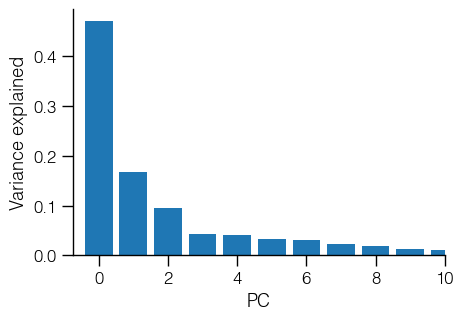

In [7]:
scale = 0.8
fig, axs = plt.subplots(1, 1, figsize=(6 * scale, 4 * scale))

explained_variance_ratios = pca.explained_variance_ratio_
axs.bar(np.arange(explained_variance_ratios.shape[0]), explained_variance_ratios)
axs.set_xlim(-0.75, 10)
axs.set_ylabel('Variance explained')
axs.set_xlabel('PC')
format_plot(axs)

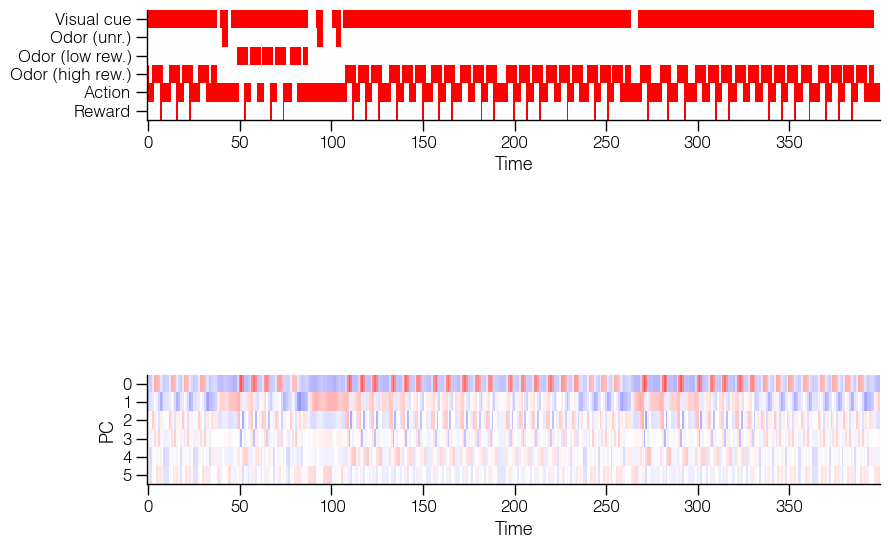

In [9]:
window = slice(2000, 2400)
trial_index = 2

scale = 1.5
fig, axs = plt.subplots(2, 1, figsize=(6 * scale, 6 * scale), sharex=True)
axs[1].matshow(pc_activities[:6, trial_index, window], cmap='bwr', vmin=-0.8, vmax=0.8, aspect=10)
axs[1].set_ylabel('PC')
axs[1].set_xlabel('Time')

inputs = np.concatenate([all_session_data[trial_index]['obs'][window, :], all_session_data[trial_index]['action'][window, np.newaxis], all_session_data[trial_index]['reward'][window, np.newaxis]], axis=1).T
axs[0].matshow(inputs, cmap='bwr', vmin=-1, vmax=1, aspect=10)
axs[0].set_yticks(np.arange(6), ['Visual cue', 'Odor (unr.)', 'Odor (low rew.)', 'Odor (high rew.)', 'Action', 'Reward'])
axs[0].set_xlabel('Time')

format_plot(axs)
fig.tight_layout()

# delays = compute_delays(1 - all_session_data[0]['action'][:500], all_session_data[0]['obs'][:500], odor_idx=2)
# scale = 1
# fig, axs = plt.subplots(1, 1, figsize=(6 * scale, 6 * scale), sharex=True)
# axs.scatter(np.arange(len(delays)), delays)

In [40]:
PATCH_TYPES_PER_ENV = 3
OBS_SIZE = PATCH_TYPES_PER_ENV + 1
ACTION_SIZE = 2
DWELL_TIME_FOR_REWARD = 6
# for actual task, reward sites are 50 cm long and interreward sites are between 20 and 100, decay rate 0.05 (truncated exp.)
REWARD_SITE_LEN = 3
INTERREWARD_SITE_LEN_BOUNDS = [1, 6]
INTEREWARD_SITE_LEN_DECAY_RATE = 0.8
REWARD_DECAY_CONSTS = [0, 10, 30]
REWARD_PROB_PREFACTOR = 0.8
# for actual task, interpatch lengths are 200 to 600 cm, decay rate 0.01 
INTERPATCH_LEN_BOUNDS = [1, 12]
INTERPATCH_LEN_DECAY_RATE = 0.1
INPUT_NOISE_STD = 0

def interreward_site_transition():
    return int(sample_truncated_exp(
        size=1,
        bounds=INTERREWARD_SITE_LEN_BOUNDS,
        decay_rate=INTEREWARD_SITE_LEN_DECAY_RATE,
    )[0])


def interpatch_transition():
    return int(sample_truncated_exp(
        size=1,
        bounds=INTERPATCH_LEN_BOUNDS,
        decay_rate=INTERPATCH_LEN_DECAY_RATE,
    )[0])

def make_stochastic_treadmill_environment(env_idx):

    def make_env():
        np.random.seed(env_idx)
        
        decay_consts_for_reward_funcs = copy(REWARD_DECAY_CONSTS)

        print('Begin stoch. treadmill')
        print(decay_consts_for_reward_funcs)

        patch_types = []
        for i in range(PATCH_TYPES_PER_ENV):
            decay_const_for_i = decay_consts_for_reward_funcs[i]
            active = (decay_const_for_i != 0)
            def reward_func(site_idx, decay_const_for_i=decay_const_for_i, active=active):
                c = REWARD_PROB_PREFACTOR * np.exp(-site_idx / decay_const_for_i) if decay_const_for_i > 0 else 0
                if np.random.rand() < c and active:
                    return 1
                else:
                    return 0
            patch_types.append(
                PatchType(
                    reward_site_len=REWARD_SITE_LEN,
                    interreward_site_len_func=interreward_site_transition,
                    reward_func=reward_func,
                    odor_num=i,
                    reward_func_param=(decay_consts_for_reward_funcs[i] if active else 0.0),
                )
            )

        transition_mat = 1/3 * np.ones((PATCH_TYPES_PER_ENV, PATCH_TYPES_PER_ENV))

        sesh = TreadmillSession(
            patch_types=patch_types,
            transition_mat=transition_mat,
            interpatch_len_func=interpatch_transition,
            dwell_time_for_reward=DWELL_TIME_FOR_REWARD,
            obs_size=PATCH_TYPES_PER_ENV + 1,
            verbosity=False,
        )

        return sesh

    return make_env

def run_input_exp(network, t_steps=300, inputs=None, give_reward=True, seed=0):
    env_seeds = np.arange(NUM_ENVS) + seed
    save_num = 0
    last_snapshot = None

    curricum = Curriculum(
        curriculum_step_starts=[0,],
        curriculum_step_env_funcs=[
            make_stochastic_treadmill_environment,
        ],
    )

    d = {}

    all_obs = []
    all_actions = []
    all_rewards = []

    with torch.no_grad():

        agent = A2CRecurrentAgent(
            network,
            action_space_dims=ACTION_SIZE,
            n_envs=NUM_ENVS,
            device=DEVICE,
            critic_weight=0, # changed for Optuna
            entropy_weight=0, # changed for Optuna
            gamma=0, # changed for Optuna
            learning_rate=0, # changed for Optuna
            activity_weight=0,
            input_noise_std=0,
        )

        envs = curricum.get_envs_for_step(env_seeds)
        # at the start of training reset all envs to get an initial state
        # play n steps in our parallel environments to collect data
        for update_num in range(t_steps):
            if update_num == 0:
                obs, info = envs.reset()

            action = agent.sample_action(obs).clone().detach().cpu().numpy()
            obs, reward, terminated, truncated, info = envs.step(action)
            if inputs is not None:
                obs = inputs[update_num, :, :4]
                reward = inputs[update_num, :, 6]

            if give_reward:
                agent.append_reward(reward.astype('float32'))
            all_rewards.append(reward)
            all_obs.append(obs)
            all_actions.append(action)

        hidden_states_for_session = agent.get_hidden_state_activities().cpu()

        d['all_hidden_out'] = hidden_states_for_session
        # print(np.array(all_obs).shape)
        # print(np.array(all_actions).shape)
        d['inputs'] = np.concatenate([
            np.array(all_obs),
            np.array(all_actions)[..., None],
             np.array(all_rewards)[..., None],
        ], axis=2)

    print(hidden_states_for_session.shape)
    print('reward_rate:', np.mean(all_rewards))
    return d


def plot_exp(network, pca, t_steps=300, action_feedback=False, selected_trial=0, window=None, inputs=None, give_reward=True, seed=0):
    d = run_input_exp(
        network,
        t_steps=t_steps,
        inputs=inputs,
        give_reward=give_reward,
        seed=seed,
    )
    
    scale = 0.8
    fig, axs = plt.subplots(3, 1, figsize=(9 * scale, 6.5 * scale), sharex=True)
    activations = d['all_hidden_out'][:, selected_trial, :].T
    axs[1].matshow(activations, aspect='auto', cmap='bwr', vmin=-0.25, vmax=0.25)

    if pca is not None:
        pc_activities = pca.transform(d['all_hidden_out'][:, selected_trial, :])
        axs[2].matshow(pc_activities.T[:10, :], aspect='auto', cmap='bwr', vmin=-0.8, vmax=0.8)
    else:
        hidden_activities = d['all_hidden_out'].numpy()
        flattened_ha = hidden_activities.reshape(hidden_activities.shape[0] * hidden_activities.shape[1], hidden_activities.shape[2], order='C')
        pca = PCA()
        pc_activities = pca.fit_transform(flattened_ha)
        pc_activities = pc_activities.reshape(hidden_activities.shape, order='C')
        axs[2].matshow(pc_activities[:, selected_trial, :10].T, aspect='auto', cmap='bwr', vmin=-0.8, vmax=0.8)
    
    axs[0].matshow(d['inputs'][:, 0, :].T, aspect='auto', cmap='bwr', vmin=-1, vmax=1)

    if window:
        axs[0].set_xlim(*window)

    axs[0].set_yticks(np.arange(6), ['Visual cue', 'Odor (unr.)', 'Odor (low rew.)', 'Odor (high rew.)', 'Move', 'Reward'])
    axs[0].set_xlabel('Time')
    axs[0].set_ylabel('Input')
    
    axs[1].set_xlabel('Time')
    axs[1].set_ylabel('Unit activity\n(RNN)')

    axs[2].set_xlabel('Time')
    axs[2].set_ylabel('PC activity')

    format_plot(axs)

    fig.tight_layout()
    
    # fig, axs = plt.subplots(1, 1, figsize=(5 * scale, 5 * scale), sharex=True)
    # corr_matrix = np.corrcoef(activations)
    # corr_matrix = np.where(~np.isnan(corr_matrix), corr_matrix, 0)
    # distance = 1 - corr_matrix

    # # Perform hierarchical clustering (average linkage)
    # linkage_matrix = linkage(distance, method='average')
    
    # # Get the optimal ordering of neurons from the clustering
    # ordering = leaves_list(linkage_matrix)
    
    # # Reorder the correlation matrix
    # ordered_corr = corr_matrix[ordering, :][:, ordering]
    
    # # Plot the heatmap
    # axs.matshow(ordered_corr, cmap='bwr', vmin=-1, vmax=1)

    return pca, pc_activities

Begin stoch. treadmill
[0, 10, 30]
torch.Size([500, 30, 128])
reward_rate: 0.0724


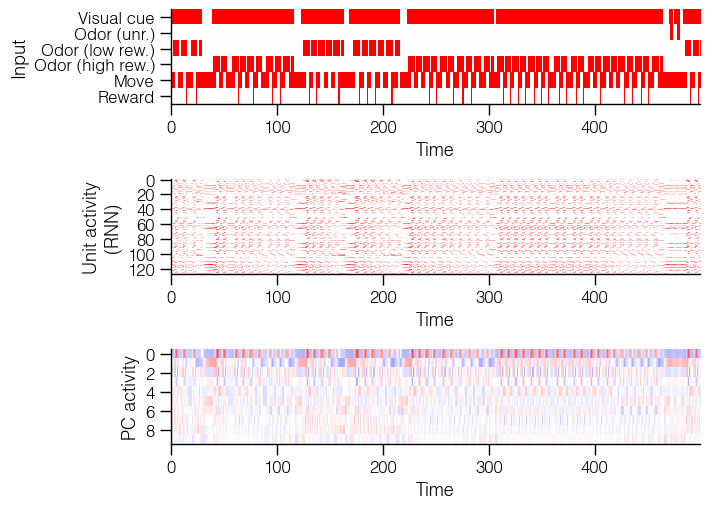

In [36]:
t_steps = 500
plot_exp(network, pca, action_feedback=True, t_steps=t_steps, selected_trial=0)
None

Begin stoch. treadmill
[0, 10, 30]
torch.Size([400, 30, 128])
reward_rate: 0.06891666666666667


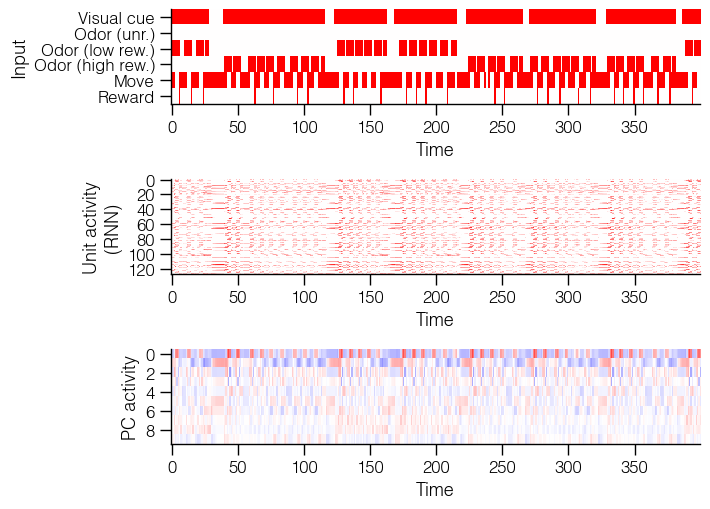

In [37]:
t_steps = 400
plot_exp(network, pca, action_feedback=True, t_steps=t_steps, selected_trial=0, give_reward=False)
None

C:\Users\david.bell\AppData\Local\Temp\ipykernel_32364\1042428466.py:51: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  m = np.abs(w_hh).max()
C:\Users\david.bell\AppData\Local\Temp\ipykernel_32364\1042428466.py:61: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  m = np.abs(b_hh).max()
C:\Users\david.bell\AppData\Local\Temp\ipykernel_32364\1042428466.py:73: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  m = np.abs(w_ih).max()


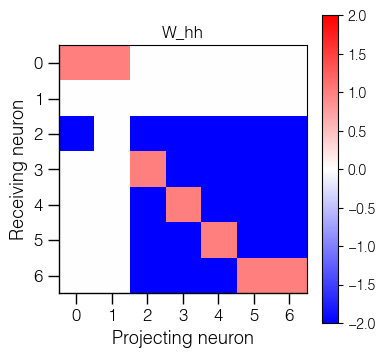

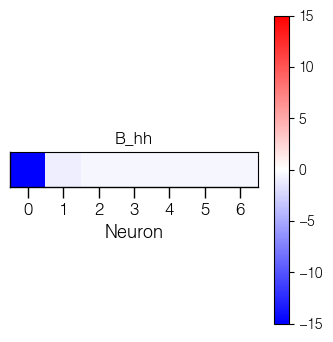

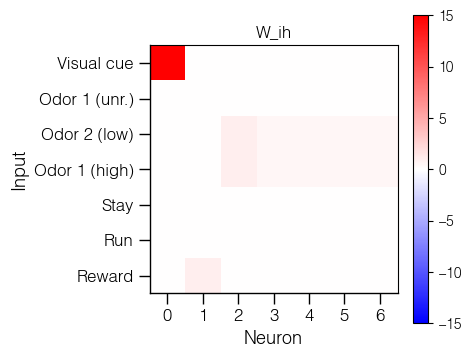

In [41]:
network = A2CRNN(
    input_size=OBS_SIZE + ACTION_SIZE + 1,
    action_size=ACTION_SIZE,
    hidden_size=7,
    device=DEVICE,
    var_noise=0,
)

global_inh = -2

w_hh = torch.zeros((7, 7)).float()
w_hh[0, 0] = 1
w_hh[0, 1] = 1
w_hh[2, 0] = -2
for k in range(3, 7):
    w_hh[k, k-1] = 3
w_hh[6, 6] = 3
w_hh[2:, 2:] += global_inh

b_hh = torch.tensor([-15, -1, -.5, -.5, -.5, -.5, -.5]).float()

w_ih = torch.tensor([
    [15, 0, 0, 0, 0, 0, 0],
    [0, 0, 0.06, 0.02, 0, 0, 1],
    [0, 0, 1, 1, 0, 0, 0],
    [0, 0, 0.5, 0.5, 0, 0, 0],
    [0, 0, 0.5, 0.5, 0, 0, 0],
    [0, 0, 0.5, 0.5, 0, 0, 0],
    [0, 0, 0.5, 0.5, 0, 0, 0],
]).float()

b_ih = torch.zeros((7))

network.rnn.weight_hh.data = w_hh.to(DEVICE)
network.rnn.bias_hh.data = b_hh.to(DEVICE)
network.rnn.weight_ih.data = w_ih.to(DEVICE)
network.rnn.bias_ih.data = b_ih.to(DEVICE)

w_action = torch.tensor([
    [0, 0, 1, 1, 1, 0, 0],
    [0, 0, 0, 0, 0, 1, 1],
]).float() * 100

bias_action = torch.tensor([-10, 10]).float()

network.action_arm.weight.data = w_action.to(DEVICE)
network.action_arm.bias.data = bias_action.to(DEVICE)

scale = 2
fig, axs = plt.subplots(1, 1, figsize=(2 * scale, 2 * scale), sharex=True)
m = np.abs(w_hh).max()
cbar = axs.matshow(w_hh, cmap='bwr', vmin=-m, vmax=m)
plt.colorbar(cbar)
axs.set_ylabel('Receiving neuron')
axs.set_xlabel('Projecting neuron')
axs.set_title('W_hh')
format_plot(axs, rightspine=True, topspine=True)

scale = 2
fig, axs = plt.subplots(1, 1, figsize=(2 * scale, 2 * scale), sharex=True)
m = np.abs(b_hh).max()
cbar = axs.matshow(b_hh[None, :], cmap='bwr', vmin=-m, vmax=m)
plt.colorbar(cbar)
axs.set_xlabel('Neuron')
axs.set_yticks([])
# axs.set_ylabel('Input')
axs.set_title('B_hh')
# axs.set_yticks(np.arange(7), ['Visual cue', 'Odor 1 (unr.)', 'Odor 2 (low)', 'Odor 1 (high)', 'Stay', 'Run', 'Reward' ])
format_plot(axs, rightspine=True, topspine=True)

scale = 2
fig, axs = plt.subplots(1, 1, figsize=(2 * scale, 2 * scale), sharex=True)
m = np.abs(w_ih).max()
cbar = axs.matshow(w_ih.T, cmap='bwr', vmin=-m, vmax=m)
plt.colorbar(cbar)
axs.set_xlabel('Neuron')
axs.set_ylabel('Input')
axs.set_title('W_ih')
axs.set_yticks(np.arange(7), ['Visual cue', 'Odor 1 (unr.)', 'Odor 2 (low)', 'Odor 1 (high)', 'Stay', 'Run', 'Reward' ])
format_plot(axs, rightspine=True, topspine=True)

Begin stoch. treadmill
[0, 10, 30]
torch.Size([400, 30, 7])
reward_rate: 0.07358333333333333


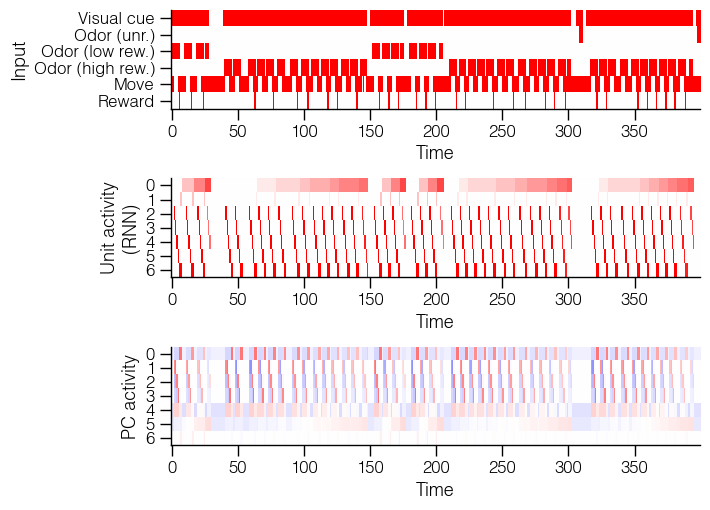

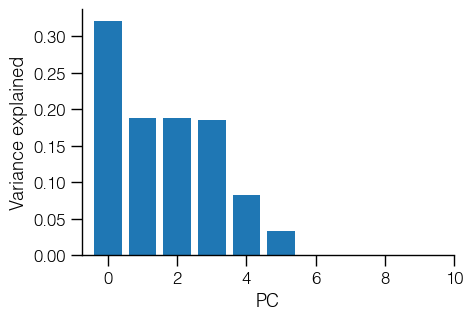

In [42]:
t_steps = 400
# append_pulsed_input(inputs, 2, 3, 30, 5, 2)
pca, pc_activities = plot_exp(network, None, action_feedback=True, t_steps=t_steps, selected_trial=0, give_reward=True)

scale = 0.8
fig, axs = plt.subplots(1, 1, figsize=(6 * scale, 4 * scale))

explained_variance_ratios = pca.explained_variance_ratio_
axs.bar(np.arange(explained_variance_ratios.shape[0]), explained_variance_ratios)
axs.set_xlim(-0.75, 10)
axs.set_ylabel('Variance explained')
axs.set_xlabel('PC')
format_plot(axs)

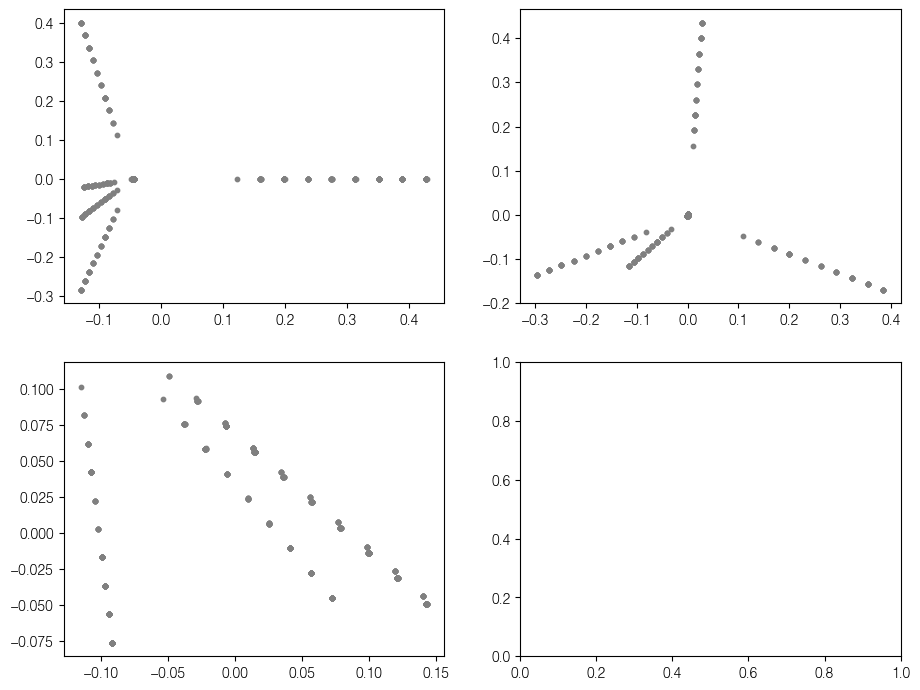

In [60]:
scale = 1.2
fig, axs = plt.subplots(2, 2, figsize=(9 * scale, 7 * scale))


for k in np.arange(0, 6, 2):
    all_mask_off = []
    k_x, k_y = int(k/4), int(k/2) % 2
    
    axs[k_x, k_y].scatter(
        pc_activities[:, 0, k],
        pc_activities[:, 0, k+1],
        s=10,
        zorder=-1,
        c='grey',
    )

Begin stoch. treadmill
[0, 10, 30]
torch.Size([20000, 30, 7])
reward_rate: 0.07333666666666666
torch.Size([20000, 30, 7])
[<Axes: xlabel='Time', ylabel='Input'>
 <Axes: xlabel='Time', ylabel='Unit activity\n(RNN)'>
 <Axes: xlabel='Time', ylabel='PC activity'>]


C:\Users\david.bell\AppData\Local\Temp\ipykernel_20792\3757594307.py:192: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = linkage(distance, method='average')


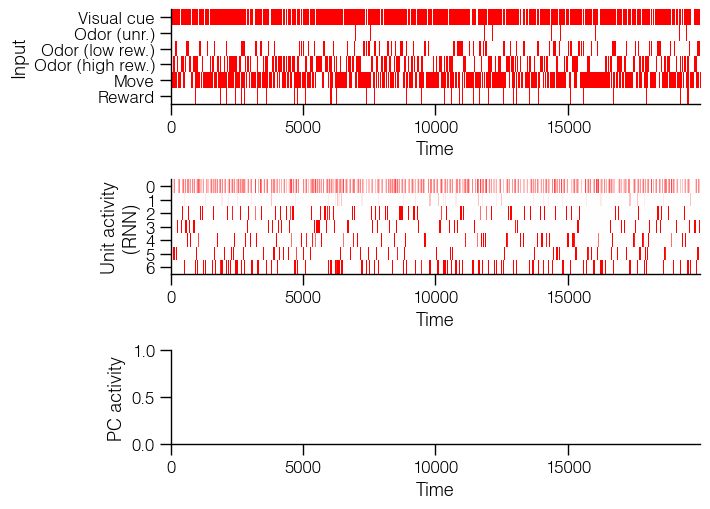

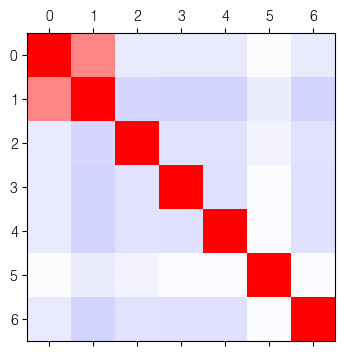

In [416]:
t_steps = 20000
# append_pulsed_input(inputs, 2, 3, 30, 5, 2)
plot_exp(network, None, action_feedback=True, t_steps=t_steps, selected_trial=0, give_reward=True)

Axes(0.125,0.11;0.62x0.77)
Axes(0.125,0.11;0.62x0.77)
Axes(0.125,0.11;0.62x0.77)


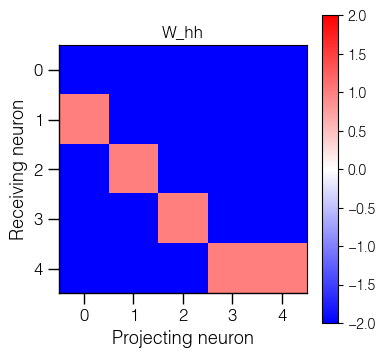

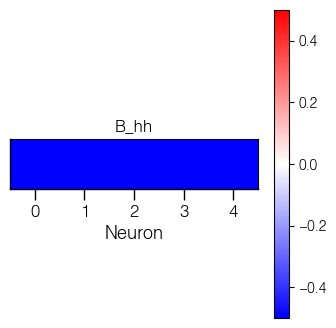

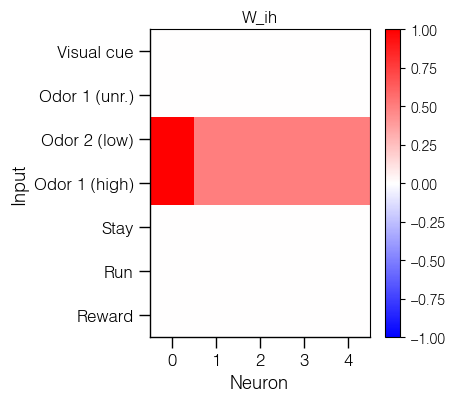

In [425]:
network = A2CRNN(
    input_size=OBS_SIZE + ACTION_SIZE + 1,
    action_size=ACTION_SIZE,
    hidden_size=5,
    device=DEVICE,
    var_noise=0,
)

global_inh = -2

w_hh = torch.zeros((5, 5)).float()
for k in range(1, 5):
    w_hh[k, k-1] = 3
w_hh[4, 4] = 3
w_hh += global_inh

b_hh = torch.tensor([-.5, -.5, -.5, -.5, -.5]).float()

w_ih = torch.tensor([
    [0, 0, 1, 1, 0, 0, 0],
    [0, 0, 0.5, 0.5, 0, 0, 0],
    [0, 0, 0.5, 0.5, 0, 0, 0],
    [0, 0, 0.5, 0.5, 0, 0, 0],
    [0, 0, 0.5, 0.5, 0, 0, 0],
]).float()

b_ih = torch.zeros((5))

network.rnn.weight_hh.data = w_hh.to(DEVICE)
network.rnn.bias_hh.data = b_hh.to(DEVICE)
network.rnn.weight_ih.data = w_ih.to(DEVICE)
network.rnn.bias_ih.data = b_ih.to(DEVICE)

w_action = torch.tensor([
    [1, 1, 1, 0, 0],
    [0, 0, 0, 1, 1],
]).float() * 100

bias_action = torch.tensor([-10, 10]).float()

network.action_arm.weight.data = w_action.to(DEVICE)
network.action_arm.bias.data = bias_action.to(DEVICE)

scale = 2
fig, axs = plt.subplots(1, 1, figsize=(2 * scale, 2 * scale), sharex=True)
m = np.abs(w_hh).max()
cbar = axs.matshow(w_hh, cmap='bwr', vmin=-m, vmax=m)
plt.colorbar(cbar)
axs.set_ylabel('Receiving neuron')
axs.set_xlabel('Projecting neuron')
axs.set_title('W_hh')
format_plot(axs, rightspine=True, topspine=True)

scale = 2
fig, axs = plt.subplots(1, 1, figsize=(2 * scale, 2 * scale), sharex=True)
m = np.abs(b_hh).max()
cbar = axs.matshow(b_hh[None, :], cmap='bwr', vmin=-m, vmax=m)
plt.colorbar(cbar)
axs.set_xlabel('Neuron')
axs.set_yticks([])
# axs.set_ylabel('Input')
axs.set_title('B_hh')
# axs.set_yticks(np.arange(7), ['Visual cue', 'Odor 1 (unr.)', 'Odor 2 (low)', 'Odor 1 (high)', 'Stay', 'Run', 'Reward' ])
format_plot(axs, rightspine=True, topspine=True)

scale = 2
fig, axs = plt.subplots(1, 1, figsize=(2 * scale, 2 * scale), sharex=True)
m = np.abs(w_ih).max()
cbar = axs.matshow(w_ih.T, cmap='bwr', vmin=-m, vmax=m)
plt.colorbar(cbar)
axs.set_xlabel('Neuron')
axs.set_ylabel('Input')
axs.set_title('W_ih')
axs.set_yticks(np.arange(7), ['Visual cue', 'Odor 1 (unr.)', 'Odor 2 (low)', 'Odor 1 (high)', 'Stay', 'Run', 'Reward' ])
format_plot(axs, rightspine=True, topspine=True)

Begin stoch. treadmill
[0, 10, 30]
torch.Size([400, 30, 5])
reward_rate: 0.05
torch.Size([400, 30, 5])
[<Axes: xlabel='Time', ylabel='Input'>
 <Axes: xlabel='Time', ylabel='Unit activity\n(RNN)'>
 <Axes: xlabel='Time', ylabel='PC activity'>]


C:\Users\david.bell\AppData\Local\Temp\ipykernel_20792\3757594307.py:192: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = linkage(distance, method='average')


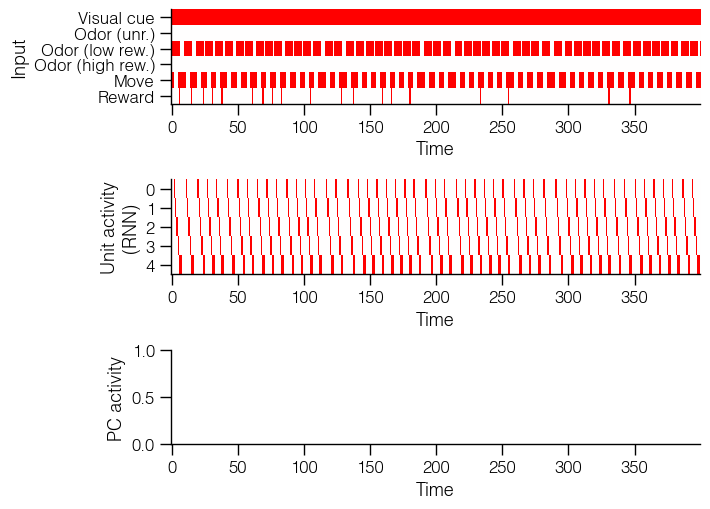

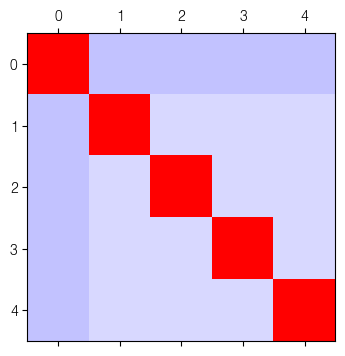

In [426]:
t_steps = 400
# append_pulsed_input(inputs, 2, 3, 30, 5, 2)
plot_exp(network, None, action_feedback=True, t_steps=t_steps, selected_trial=0, give_reward=True)

Axes(0.125,0.11;0.62x0.77)
Axes(0.125,0.11;0.62x0.77)
Axes(0.125,0.11;0.62x0.77)


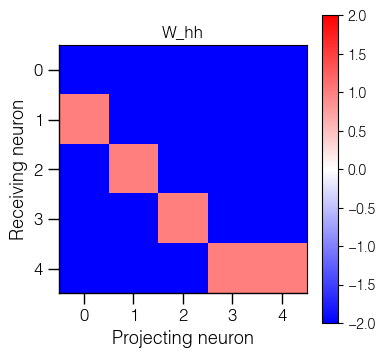

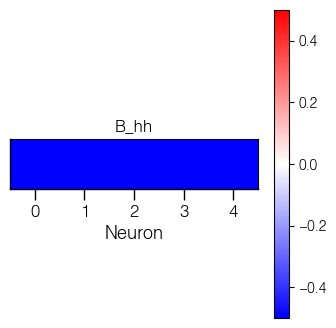

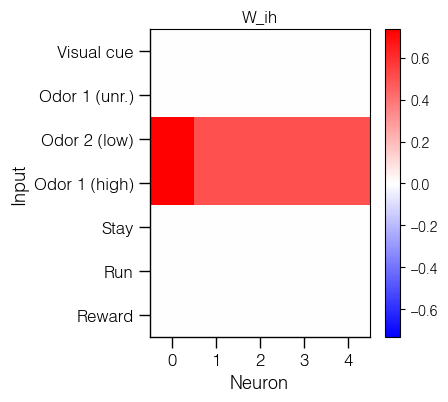

In [445]:
network = A2CRNN(
    input_size=OBS_SIZE + ACTION_SIZE + 1,
    action_size=ACTION_SIZE,
    hidden_size=5,
    device=DEVICE,
    var_noise=0,
)

global_inh = -2

w_hh = torch.zeros((5, 5)).float()
for k in range(1, 5):
    w_hh[k, k-1] = 3
w_hh[4, 4] = 3
w_hh += global_inh

b_hh = torch.tensor([-.5, -.5, -.5, -.5, -.5]).float()

w_ih = torch.tensor([
    [0, 0, 0.725, 0.735, 0, 0, 0],
    [0, 0, 0.5, 0.5, 0, 0, 0],
    [0, 0, 0.5, 0.5, 0, 0, 0],
    [0, 0, 0.5, 0.5, 0, 0, 0],
    [0, 0, 0.5, 0.5, 0, 0, 0],
]).float()

b_ih = torch.zeros((5))

network.rnn.weight_hh.data = w_hh.to(DEVICE)
network.rnn.bias_hh.data = b_hh.to(DEVICE)
network.rnn.weight_ih.data = w_ih.to(DEVICE)
network.rnn.bias_ih.data = b_ih.to(DEVICE)

w_action = torch.tensor([
    [1, 1, 1, 0, 0],
    [0, 0, 0, 1, 1],
]).float() * 100

bias_action = torch.tensor([-10, 10]).float()

network.action_arm.weight.data = w_action.to(DEVICE)
network.action_arm.bias.data = bias_action.to(DEVICE)

scale = 2
fig, axs = plt.subplots(1, 1, figsize=(2 * scale, 2 * scale), sharex=True)
m = np.abs(w_hh).max()
cbar = axs.matshow(w_hh, cmap='bwr', vmin=-m, vmax=m)
plt.colorbar(cbar)
axs.set_ylabel('Receiving neuron')
axs.set_xlabel('Projecting neuron')
axs.set_title('W_hh')
format_plot(axs, rightspine=True, topspine=True)

scale = 2
fig, axs = plt.subplots(1, 1, figsize=(2 * scale, 2 * scale), sharex=True)
m = np.abs(b_hh).max()
cbar = axs.matshow(b_hh[None, :], cmap='bwr', vmin=-m, vmax=m)
plt.colorbar(cbar)
axs.set_xlabel('Neuron')
axs.set_yticks([])
# axs.set_ylabel('Input')
axs.set_title('B_hh')
# axs.set_yticks(np.arange(7), ['Visual cue', 'Odor 1 (unr.)', 'Odor 2 (low)', 'Odor 1 (high)', 'Stay', 'Run', 'Reward' ])
format_plot(axs, rightspine=True, topspine=True)

scale = 2
fig, axs = plt.subplots(1, 1, figsize=(2 * scale, 2 * scale), sharex=True)
m = np.abs(w_ih).max()
cbar = axs.matshow(w_ih.T, cmap='bwr', vmin=-m, vmax=m)
plt.colorbar(cbar)
axs.set_xlabel('Neuron')
axs.set_ylabel('Input')
axs.set_title('W_ih')
axs.set_yticks(np.arange(7), ['Visual cue', 'Odor 1 (unr.)', 'Odor 2 (low)', 'Odor 1 (high)', 'Stay', 'Run', 'Reward' ])
format_plot(axs, rightspine=True, topspine=True)

Begin stoch. treadmill
[0, 10, 30]
torch.Size([400, 30, 5])
reward_rate: 0.06508333333333334
torch.Size([400, 30, 5])
[<Axes: xlabel='Time', ylabel='Input'>
 <Axes: xlabel='Time', ylabel='Unit activity\n(RNN)'>
 <Axes: xlabel='Time', ylabel='PC activity'>]


C:\Users\david.bell\AppData\Local\Temp\ipykernel_20792\3757594307.py:192: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = linkage(distance, method='average')


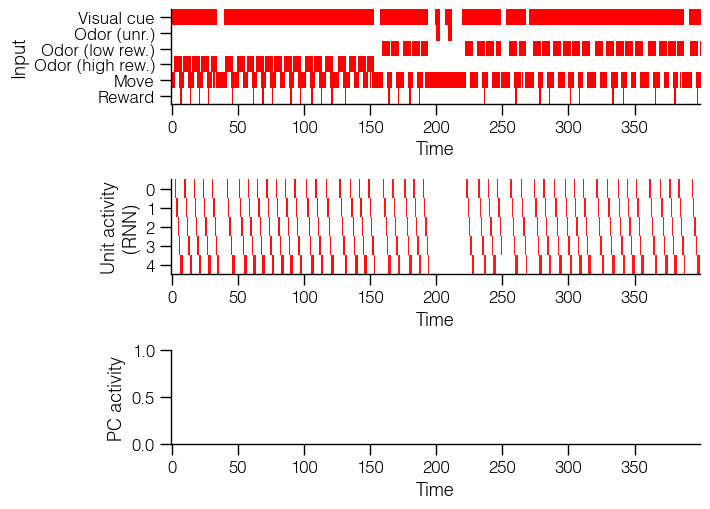

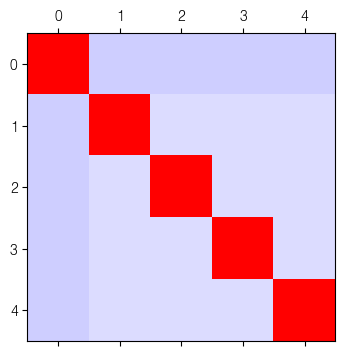

In [449]:
t_steps = 400
# append_pulsed_input(inputs, 2, 3, 30, 5, 2)
plot_exp(network, None, action_feedback=True, t_steps=t_steps, selected_trial=0, give_reward=True, seed=700)

Begin stoch. treadmill
[0, 10, 30]
torch.Size([5000, 30, 5])
reward_rate: 0.06445333333333333
torch.Size([5000, 30, 5])
[<Axes: xlabel='Time', ylabel='Input'>
 <Axes: xlabel='Time', ylabel='Unit activity\n(RNN)'>
 <Axes: xlabel='Time', ylabel='PC activity'>]


C:\Users\david.bell\AppData\Local\Temp\ipykernel_20792\3757594307.py:192: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = linkage(distance, method='average')


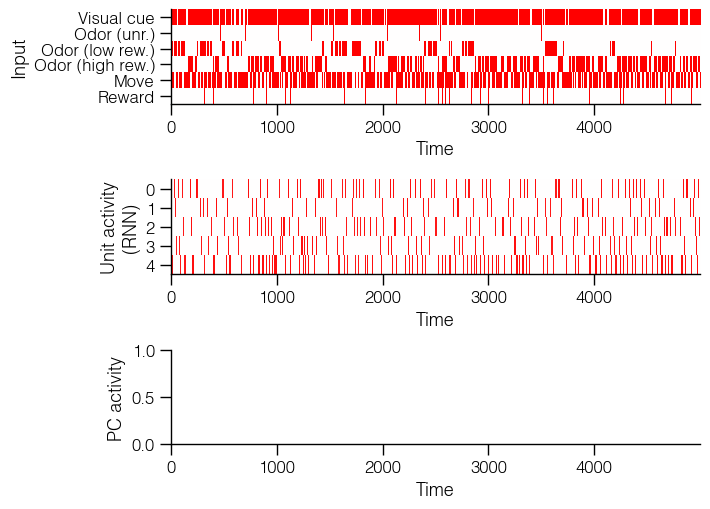

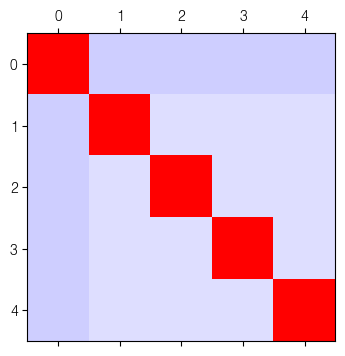

In [447]:
t_steps = 5000
# append_pulsed_input(inputs, 2, 3, 30, 5, 2)
plot_exp(network, None, action_feedback=True, t_steps=t_steps, selected_trial=0, give_reward=True, seed=500)

In [11]:
def append_pulsed_input(inputs, index, onset, n_cycles, on_period, off_period):
    v = np.empty(int(n_cycles * (on_period + off_period)))
    for c in range(n_cycles):
        period_start = onset + (on_period + off_period) * c
        inputs[period_start : period_start + on_period, :, index] = 1
        inputs[period_start + on_period : period_start + on_period + off_period, :, index] = 0

Begin stoch. treadmill
[0, 10, 30]
torch.Size([400, 30, 128])
reward_rate: 0.0
torch.Size([400, 30, 128])
[<Axes: xlabel='Time', ylabel='Input'>
 <Axes: xlabel='Time', ylabel='Unit activity\n(RNN)'>
 <Axes: xlabel='Time', ylabel='PC activity'> <Axes: > <Axes: > <Axes: >]


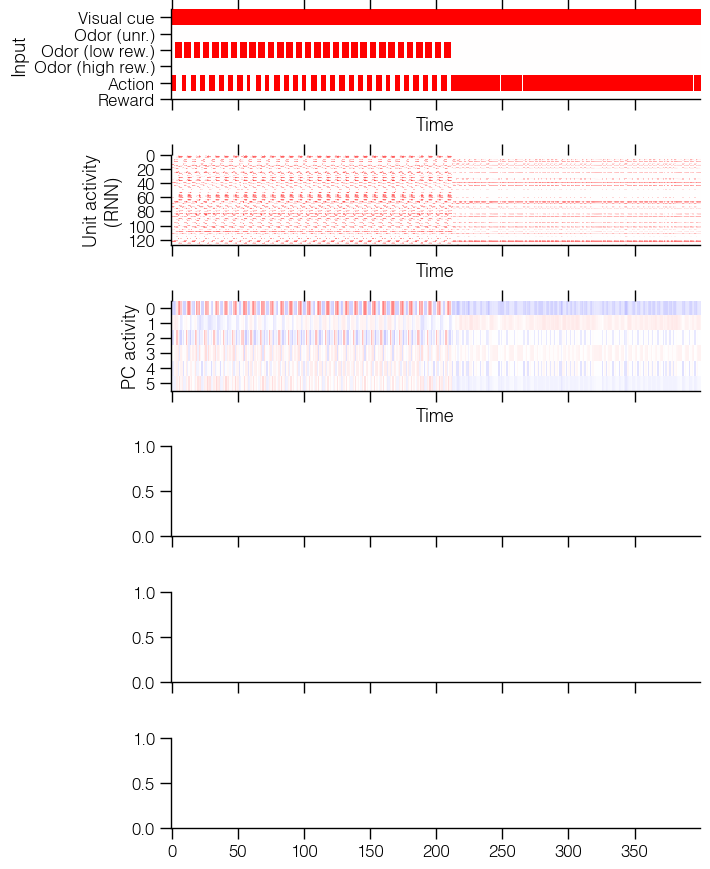

In [100]:
t_steps = 400
inputs = np.zeros((t_steps, NUM_ENVS, 7)).astype('float32')
inputs[..., 0] = 1
append_pulsed_input(inputs, 2, 3, 30, 5, 2)
plot_exp(network, pca, action_feedback=True, t_steps=t_steps, inputs=inputs, selected_trial=6)

Begin stoch. treadmill
[0, 10, 30]
torch.Size([400, 30, 128])
reward_rate: 0.0
torch.Size([400, 30, 128])
[<Axes: xlabel='Time', ylabel='Input'>
 <Axes: xlabel='Time', ylabel='Unit activity\n(RNN)'>
 <Axes: xlabel='Time', ylabel='PC activity'> <Axes: > <Axes: > <Axes: >]


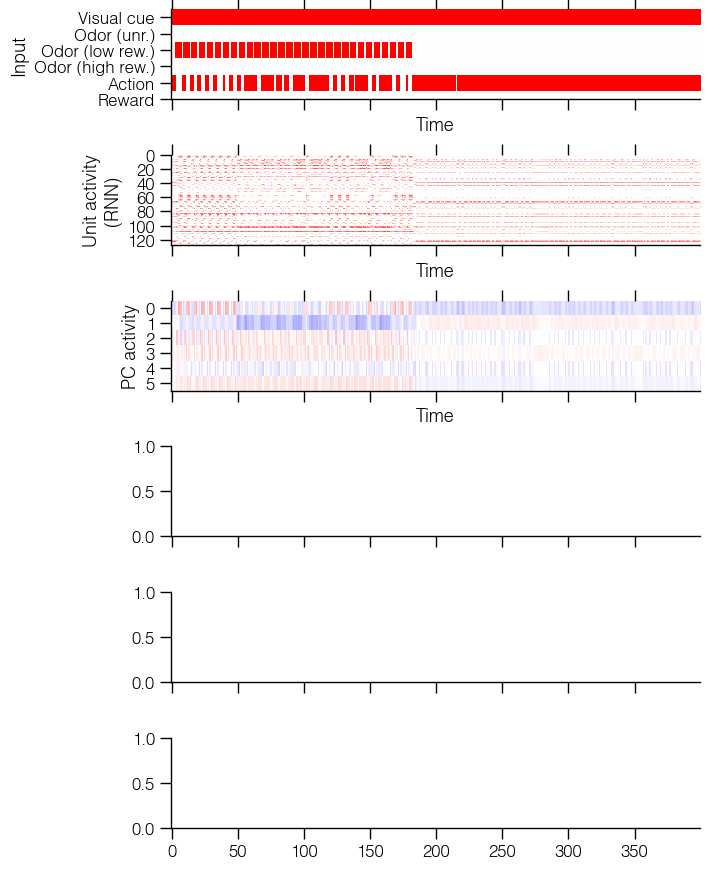

In [101]:
t_steps = 400
inputs = np.zeros((t_steps, NUM_ENVS, 7)).astype('float32')
inputs[..., 0] = 1
append_pulsed_input(inputs, 2, 3, 30, 5, 1)
plot_exp(network, pca, action_feedback=True, t_steps=t_steps, inputs=inputs, selected_trial=6)

Begin stoch. treadmill
[0, 10, 30]
torch.Size([400, 30, 128])
reward_rate: 0.0
torch.Size([400, 30, 128])
[<Axes: xlabel='Time', ylabel='Input'>
 <Axes: xlabel='Time', ylabel='Unit activity\n(RNN)'>
 <Axes: xlabel='Time', ylabel='PC activity'> <Axes: > <Axes: > <Axes: >]


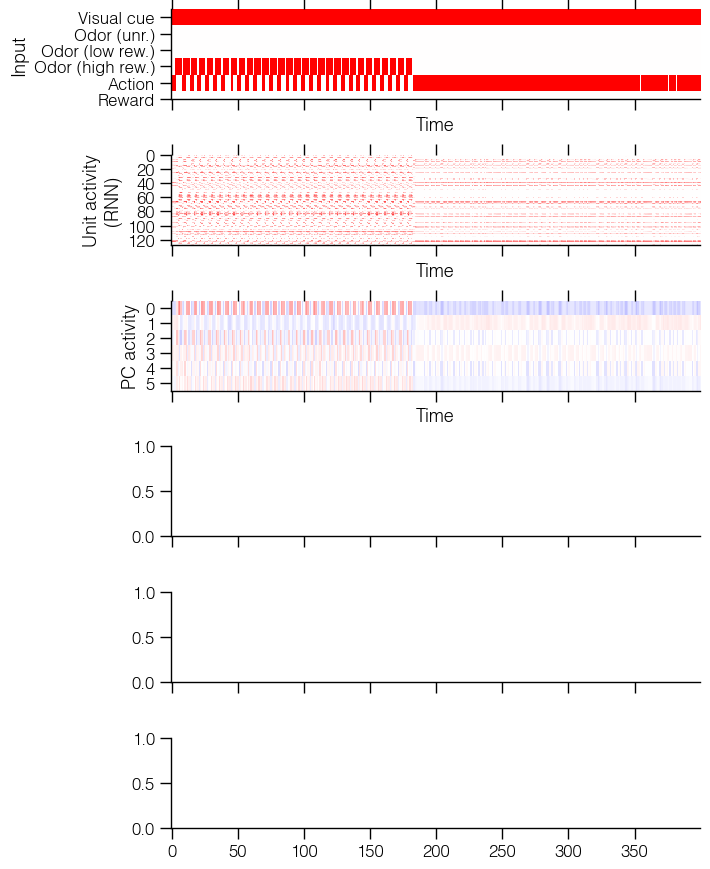

In [97]:
t_steps = 400
inputs = np.zeros((t_steps, NUM_ENVS, 7)).astype('float32')
inputs[..., 0] = 1
append_pulsed_input(inputs, 3, 3, 30, 5, 1)
plot_exp(network, pca, action_feedback=True, t_steps=t_steps, inputs=inputs, selected_trial=6)

Begin stoch. treadmill
[0, 10, 30]
torch.Size([400, 30, 128])
reward_rate: 0.0
torch.Size([400, 30, 128])
[<Axes: xlabel='Time', ylabel='Input'>
 <Axes: xlabel='Time', ylabel='Unit activity\n(RNN)'>
 <Axes: xlabel='Time', ylabel='PC activity'> <Axes: > <Axes: > <Axes: >]


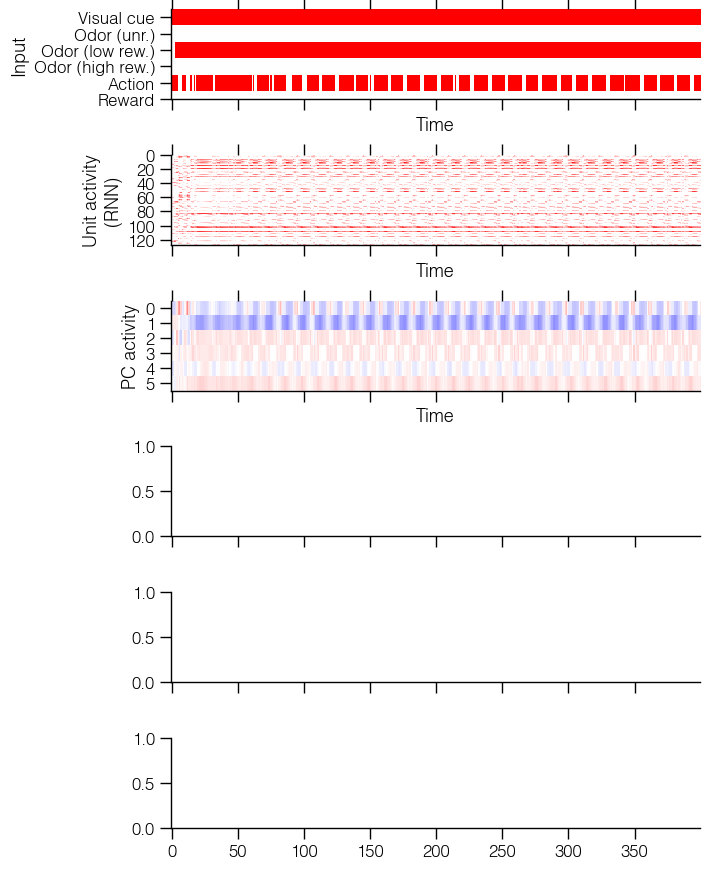

In [103]:
t_steps = 400
inputs = np.zeros((t_steps, NUM_ENVS, 7)).astype('float32')
inputs[..., 0] = 1
inputs[3:, :, 2] = 1
plot_exp(network, pca, action_feedback=True, t_steps=t_steps, inputs=inputs, selected_trial=6)

Begin stoch. treadmill
[0, 10, 30]
torch.Size([400, 30, 128])
reward_rate: 0.0
torch.Size([400, 30, 128])
[<Axes: xlabel='Time', ylabel='Input'>
 <Axes: xlabel='Time', ylabel='Unit activity\n(RNN)'>
 <Axes: xlabel='Time', ylabel='PC activity'> <Axes: > <Axes: > <Axes: >]


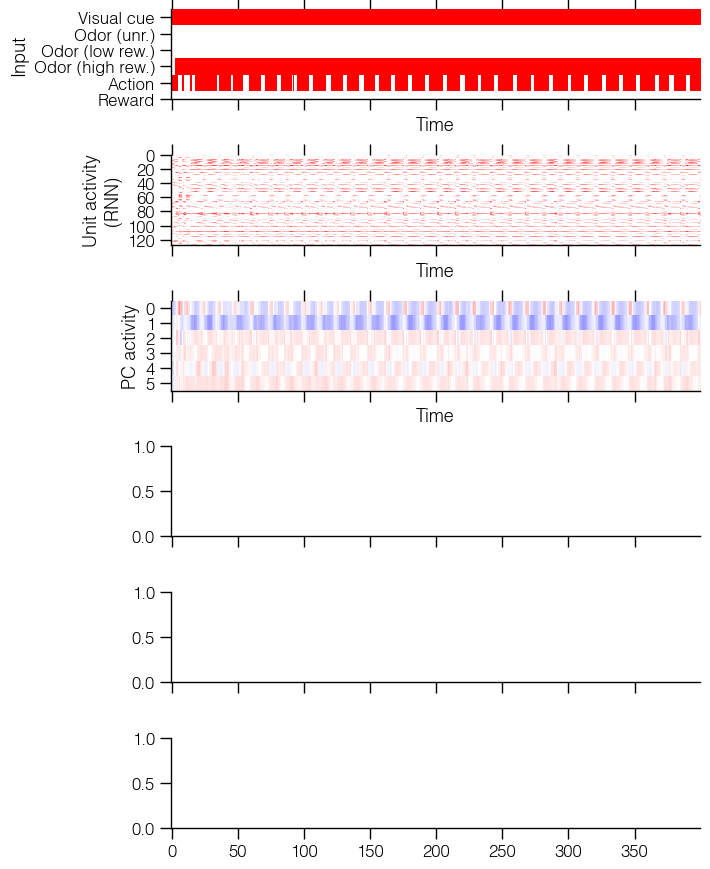

In [104]:
t_steps = 400
inputs = np.zeros((t_steps, NUM_ENVS, 7)).astype('float32')
inputs[..., 0] = 1
inputs[3:, :, 3] = 1
plot_exp(network, pca, action_feedback=True, t_steps=t_steps, inputs=inputs, selected_trial=6)

torch.Size([300, 2, 202])
torch.Size([300, 2, 202])
torch.Size([300, 2, 202])
torch.Size([300, 2, 202])
torch.Size([300, 2, 202])
torch.Size([300, 2, 202])
Axes(0.125,0.11;0.62x0.77)


C:\Users\david.bell\AppData\Local\Temp\ipykernel_10808\1508281176.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap(color_scheme, n)  # Discretize colormap into n colors


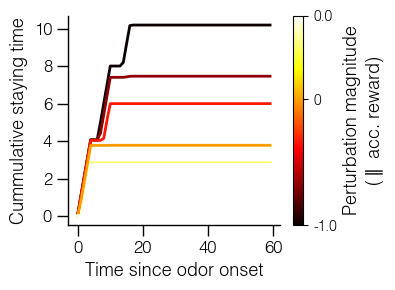

In [71]:
scale = 1
fig, axs = plt.subplots(1, 1, figsize=(4 * scale, 3 * scale), sharex=True)
color_scheme = 'hot'

n = inputs.shape[0]
cmap = mpl.cm.get_cmap(color_scheme, n)  # Discretize colormap into n colors
colors = [cmap(i) for i in range(n)]
 
for i, d in enumerate(data):
    print(d['action_probs_totals'].shape)
    axs.plot(np.arange(110 - 50), d['action_probs_totals'][50:110, 0, 0], lw=2, color=colors[i])

norm = mpl.colors.Normalize(vmin=0, vmax=n - 1)
sm = mpl.cm.ScalarMappable(cmap=color_scheme, norm=norm)
sm.set_array([])  # required for colorbar, even if unused
cbar = fig.colorbar(sm, ax=axs, ticks=[0, int(n/2), n-1])
cbar.set_ticklabels([pert_sizes[0], 0, pert_sizes[-1]])
cbar.set_label('Perturbation magnitude\n' + r'($\parallel$ acc. reward)', fontsize=13)

axs.set_ylabel('Cummulative staying time')
axs.set_xlabel('Time since odor onset')
# axs.set_ylim(0, 35)
format_plot(axs)
fig.tight_layout()

Axes(0.125,0.11;0.775x0.77)


C:\Users\david.bell\AppData\Local\Temp\ipykernel_10808\2985963865.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap(color_scheme, n)  # Discretize colormap into n colors


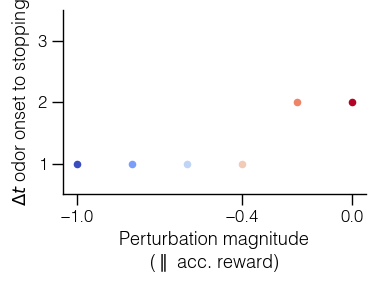

In [73]:
scale = 1
fig, axs = plt.subplots(1, 1, figsize=(4 * scale, 3 * scale), sharex=True)
color_scheme = 'coolwarm'

n = inputs.shape[0]
cmap = mpl.cm.get_cmap(color_scheme, n)  # Discretize colormap into n colors
colors = [cmap(i) for i in range(n)]
 
for i, d in enumerate(data):
    stay_prob = d['action_probs'][50:110, 0, 0]
    first_moment_staying = np.arange(len(stay_prob))[stay_prob > 0.5][0]
    
    axs.scatter(pert_sizes[i], first_moment_staying, color=colors[i], s=20)
pert_sizes_summary = [pert_sizes[0], pert_sizes[int(n/2)], pert_sizes[-1]]
axs.set_xticks(pert_sizes_summary)
axs.set_ylim(0.5, 3.5)

# norm = mpl.colors.Normalize(vmin=0, vmax=n - 1)
# sm = mpl.cm.ScalarMappable(cmap=color_scheme, norm=norm)
# sm.set_array([])  # required for colorbar, even if unused
# cbar = fig.colorbar(sm, ax=axs, ticks=range(n))
# cbar.set_ticklabels([-0.5, -0.25, 0, 0.25, 0.5])
# cbar.set_label('Perturbation magnitude\n' + r'($\parallel$ acc. reward)', fontsize=13)

axs.set_ylabel(r'$\Delta t$ odor onset to stopping')
axs.set_xlabel('Perturbation magnitude\n' + r'($\parallel$ acc. reward)')
format_plot(axs)
fig.tight_layout()

In [74]:
t_steps = 300
pert_sizes = np.array([-0.5, -0.4, -0.3, -0.2, -0.1, 0]) * 2
n_exps = len(pert_sizes)
inputs = torch.zeros(n_exps, t_steps, network_states.shape[0], OBS_SIZE + ACTION_SIZE + 1)
inputs[:, :250, :, 0] = 1
inputs[:, 50:250, :, 3] = 1
p = torch.zeros(n_exps, t_steps)
for i, ps in enumerate(pert_sizes):
    p[i, 25] = ps
data = run_mult_input_exps(network, inputs, acc_reward_vec, t_steps=t_steps, proj_vec_intervention_set=p)

torch.Size([300, 2, 202])
torch.Size([300, 2, 202])
torch.Size([300, 2, 202])
torch.Size([300, 2, 202])
torch.Size([300, 2, 202])
torch.Size([300, 2, 202])
Axes(0.125,0.11;0.62x0.77)


C:\Users\david.bell\AppData\Local\Temp\ipykernel_10808\2107256624.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap(color_scheme, n)  # Discretize colormap into n colors


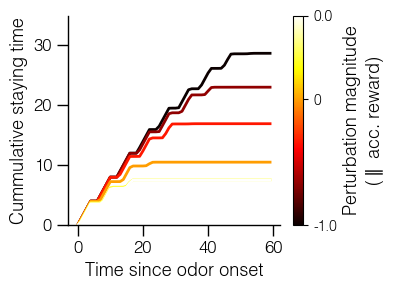

In [75]:
scale = 1
fig, axs = plt.subplots(1, 1, figsize=(4 * scale, 3 * scale), sharex=True)
color_scheme = 'hot'

n = inputs.shape[0]
cmap = mpl.cm.get_cmap(color_scheme, n)  # Discretize colormap into n colors
colors = [cmap(i) for i in range(n)]
 
for i, d in enumerate(data):
    print(d['action_probs_totals'].shape)
    axs.plot(np.arange(110 - 50), d['action_probs_totals'][50:110, 0, 0], lw=2, color=colors[i])

norm = mpl.colors.Normalize(vmin=0, vmax=n - 1)
sm = mpl.cm.ScalarMappable(cmap=color_scheme, norm=norm)
sm.set_array([])  # required for colorbar, even if unused
cbar = fig.colorbar(sm, ax=axs, ticks=[0, int(n/2), n-1])
cbar.set_ticklabels([pert_sizes[0], 0, pert_sizes[-1]])
cbar.set_label('Perturbation magnitude\n' + r'($\parallel$ acc. reward)', fontsize=13)

axs.set_ylabel('Cummulative staying time')
axs.set_xlabel('Time since odor onset')
axs.set_ylim(0, 35)
format_plot(axs)
fig.tight_layout()

Axes(0.125,0.11;0.775x0.77)


C:\Users\david.bell\AppData\Local\Temp\ipykernel_10808\2985963865.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap(color_scheme, n)  # Discretize colormap into n colors


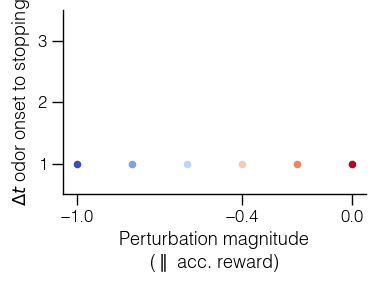

In [76]:
scale = 1
fig, axs = plt.subplots(1, 1, figsize=(4 * scale, 3 * scale), sharex=True)
color_scheme = 'coolwarm'

n = inputs.shape[0]
cmap = mpl.cm.get_cmap(color_scheme, n)  # Discretize colormap into n colors
colors = [cmap(i) for i in range(n)]
 
for i, d in enumerate(data):
    stay_prob = d['action_probs'][50:110, 0, 0]
    first_moment_staying = np.arange(len(stay_prob))[stay_prob > 0.5][0]
    
    axs.scatter(pert_sizes[i], first_moment_staying, color=colors[i], s=20)
pert_sizes_summary = [pert_sizes[0], pert_sizes[int(n/2)], pert_sizes[-1]]
axs.set_xticks(pert_sizes_summary)
axs.set_ylim(0.5, 3.5)

# norm = mpl.colors.Normalize(vmin=0, vmax=n - 1)
# sm = mpl.cm.ScalarMappable(cmap=color_scheme, norm=norm)
# sm.set_array([])  # required for colorbar, even if unused
# cbar = fig.colorbar(sm, ax=axs, ticks=range(n))
# cbar.set_ticklabels([-0.5, -0.25, 0, 0.25, 0.5])
# cbar.set_label('Perturbation magnitude\n' + r'($\parallel$ acc. reward)', fontsize=13)

axs.set_ylabel(r'$\Delta t$ odor onset to stopping')
axs.set_xlabel('Perturbation magnitude\n' + r'($\parallel$ acc. reward)')
format_plot(axs)
fig.tight_layout()

In [39]:
def append_pulsed_input(inputs, index, onset, n_cycles, on_period, off_period):
    v = np.empty(int(n_cycles * (on_period + off_period)))
    for c in range(n_cycles):
        period_start = onset + (on_period + off_period) * c
        inputs[period_start : period_start + on_period, :, index] = 1
        inputs[period_start + on_period : period_start + on_period + off_period, :, index] = 0